# Gas Pipeline Anomaly Detection - Clean Training Pipeline

**Goal**: Train a One-Class SVM model for real-time anomaly detection

**Data**: Azerbaijan gas pipeline sensors (Mardakan, Sumqayit, Turkan)

**Output**: Production-ready model + scaler for dashboard

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
ARTIFACTS_DIR = BASE_DIR / "artifacts"
OUTPUTS_DIR = BASE_DIR / "outputs"
CHARTS_DIR = BASE_DIR / "charts"

# Create directories
ARTIFACTS_DIR.mkdir(exist_ok=True)
OUTPUTS_DIR.mkdir(exist_ok=True)
CHARTS_DIR.mkdir(exist_ok=True)

print("✓ Setup complete")

✓ Setup complete


In [2]:
# Column mapping (Azerbaijani → English)
COLUMN_MAP = {
    "TARİX": "timestamp",
    "XÜSUSİ ÇƏKİ\n(kq/m3)": "density_kg_m3",
    "TƏZYİQLƏR\nFƏRQİ (kPa)": "pressure_diff_kpa",
    "TƏZYİQ (kPa)": "pressure_kpa",
    "TEMPERATUR\n(C)": "temperature_c",
    "SAATLIQ\nSƏRF(min m3)": "hourly_flow_m3",
    "SƏRF (min m3)": "total_flow_m3",
}

# Load and combine all locations
dfs = []
for location in ["Mardakan", "Sumqayit", "Turkan"]:
    df = pd.read_csv(DATA_DIR / f"{location}.csv")
    df = df.rename(columns=COLUMN_MAP)
    df["location"] = location
    dfs.append(df)
    print(f"✓ Loaded {location}: {len(df):,} rows")

df = pd.concat(dfs, ignore_index=True)
print(f"\n✓ Combined: {len(df):,} total rows")

✓ Loaded Mardakan: 57,978 rows
✓ Loaded Sumqayit: 58,011 rows
✓ Loaded Turkan: 57,978 rows

✓ Combined: 173,967 total rows


## 2. Data Cleaning & Feature Engineering

In [3]:
# Remove nulls
df = df.dropna()
print(f"After cleaning: {len(df):,} rows")

# Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, format='mixed')

# Extract temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

print("✓ Feature engineering complete")

After cleaning: 170,289 rows


✓ Feature engineering complete


## 3. Exploratory Data Analysis (EDA)

### 3.1 Data Overview

In [4]:
# Basic statistics
print("="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nRecords per location:")
print(df['location'].value_counts())
print(f"\nYear distribution:")
print(df['year'].value_counts().sort_index())

# Sensor statistics
sensor_cols = ["density_kg_m3", "pressure_diff_kpa", "pressure_kpa", 
               "temperature_c", "hourly_flow_m3", "total_flow_m3"]

print("\n" + "="*70)
print("SENSOR STATISTICS")
print("="*70)
print(df[sensor_cols].describe())

DATA OVERVIEW

Dataset shape: (170289, 12)
Date range: 2018-01-01 01:00:00 to 2024-08-21 16:00:00

Records per location:
location
Mardakan    57327
Sumqayit    56637
Turkan      56325
Name: count, dtype: int64

Year distribution:
year
2018    26277
2019    25963
2020    25861
2021    25550
2022    25274
2023    25409
2024    15955
Name: count, dtype: int64

SENSOR STATISTICS
       density_kg_m3  pressure_diff_kpa   pressure_kpa  temperature_c  \
count  170289.000000      170289.000000  170289.000000  170289.000000   
mean        0.739360           9.209971     485.650572      16.324738   
std         0.013998           8.030006      95.800057      17.369537   
min         0.000000          -0.984000       0.000000     -34.568000   
25%         0.727770           3.153700     411.840000       8.232000   
50%         0.734700           7.382900     487.077000      15.212000   
75%         0.752790          12.887300     561.744000      23.389000   
max         1.000000          69.13200

### 3.2 Sensor Distributions

✓ Saved: charts/01_sensor_distributions.png


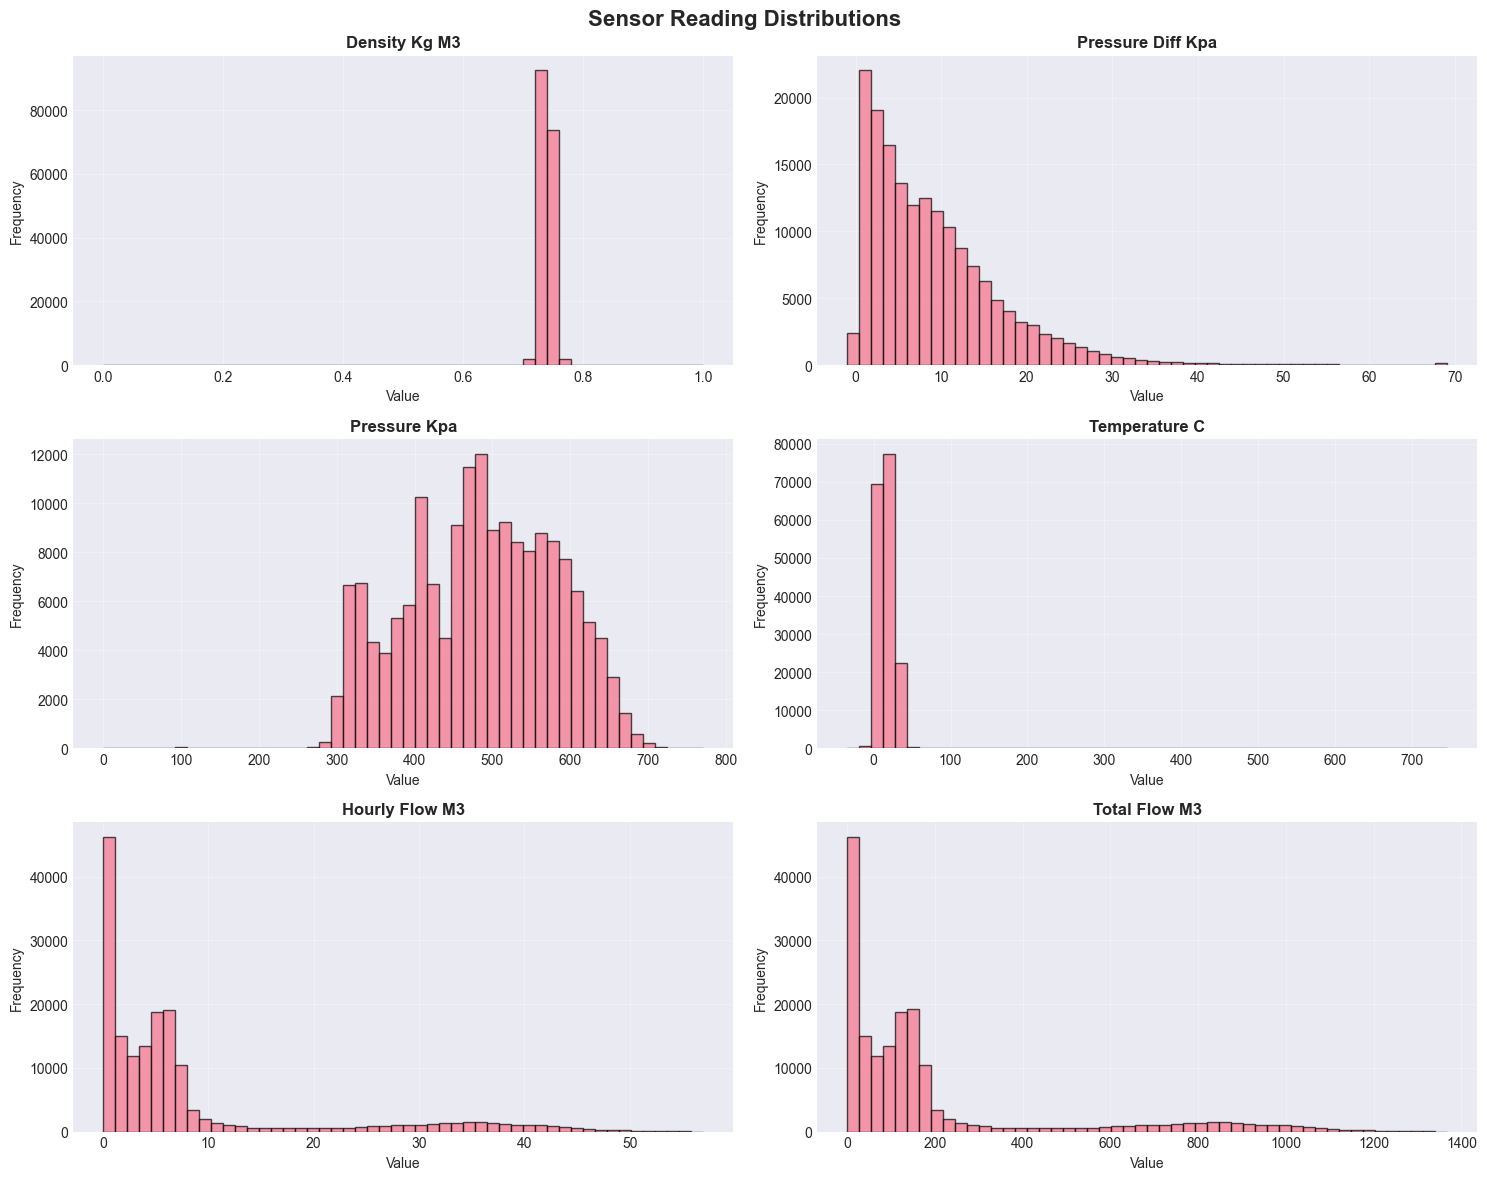

In [5]:
# Distribution plots for all sensors
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Sensor Reading Distributions', fontsize=16, fontweight='bold')

for idx, col in enumerate(sensor_cols):
    row = idx // 2
    col_idx = idx % 2
    ax = axes[row, col_idx]
    
    # Histogram with KDE
    df[col].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
    ax.set_title(f'{col.replace("_", " ").title()}', fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CHARTS_DIR / '01_sensor_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: charts/01_sensor_distributions.png")
plt.show()

### 3.3 Correlation Analysis

✓ Saved: charts/02_correlation_heatmap.png


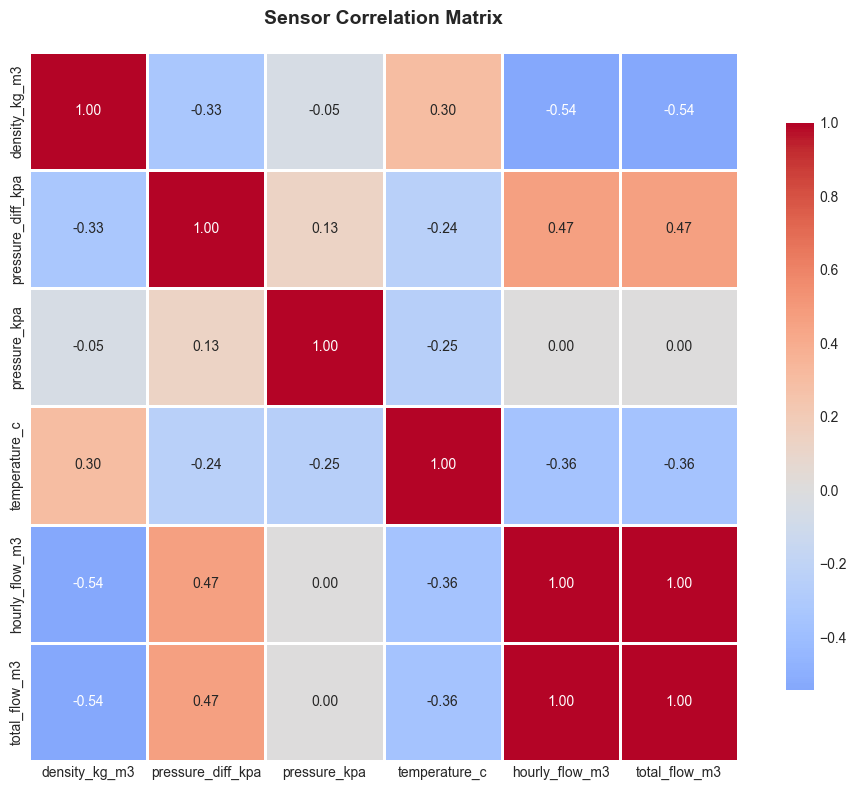


Strong Correlations (|r| > 0.5):
density_kg_m3        <-> hourly_flow_m3      : -0.544
density_kg_m3        <-> total_flow_m3       : -0.544
hourly_flow_m3       <-> total_flow_m3       :  1.000


In [6]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[sensor_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Sensor Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(CHARTS_DIR / '02_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: charts/02_correlation_heatmap.png")
plt.show()

# Print strong correlations
print("\nStrong Correlations (|r| > 0.5):")
print("="*50)
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"{correlation_matrix.columns[i]:20s} <-> {correlation_matrix.columns[j]:20s}: {corr_val:6.3f}")

### 3.4 Location Comparison

✓ Saved: charts/03_location_comparison.png


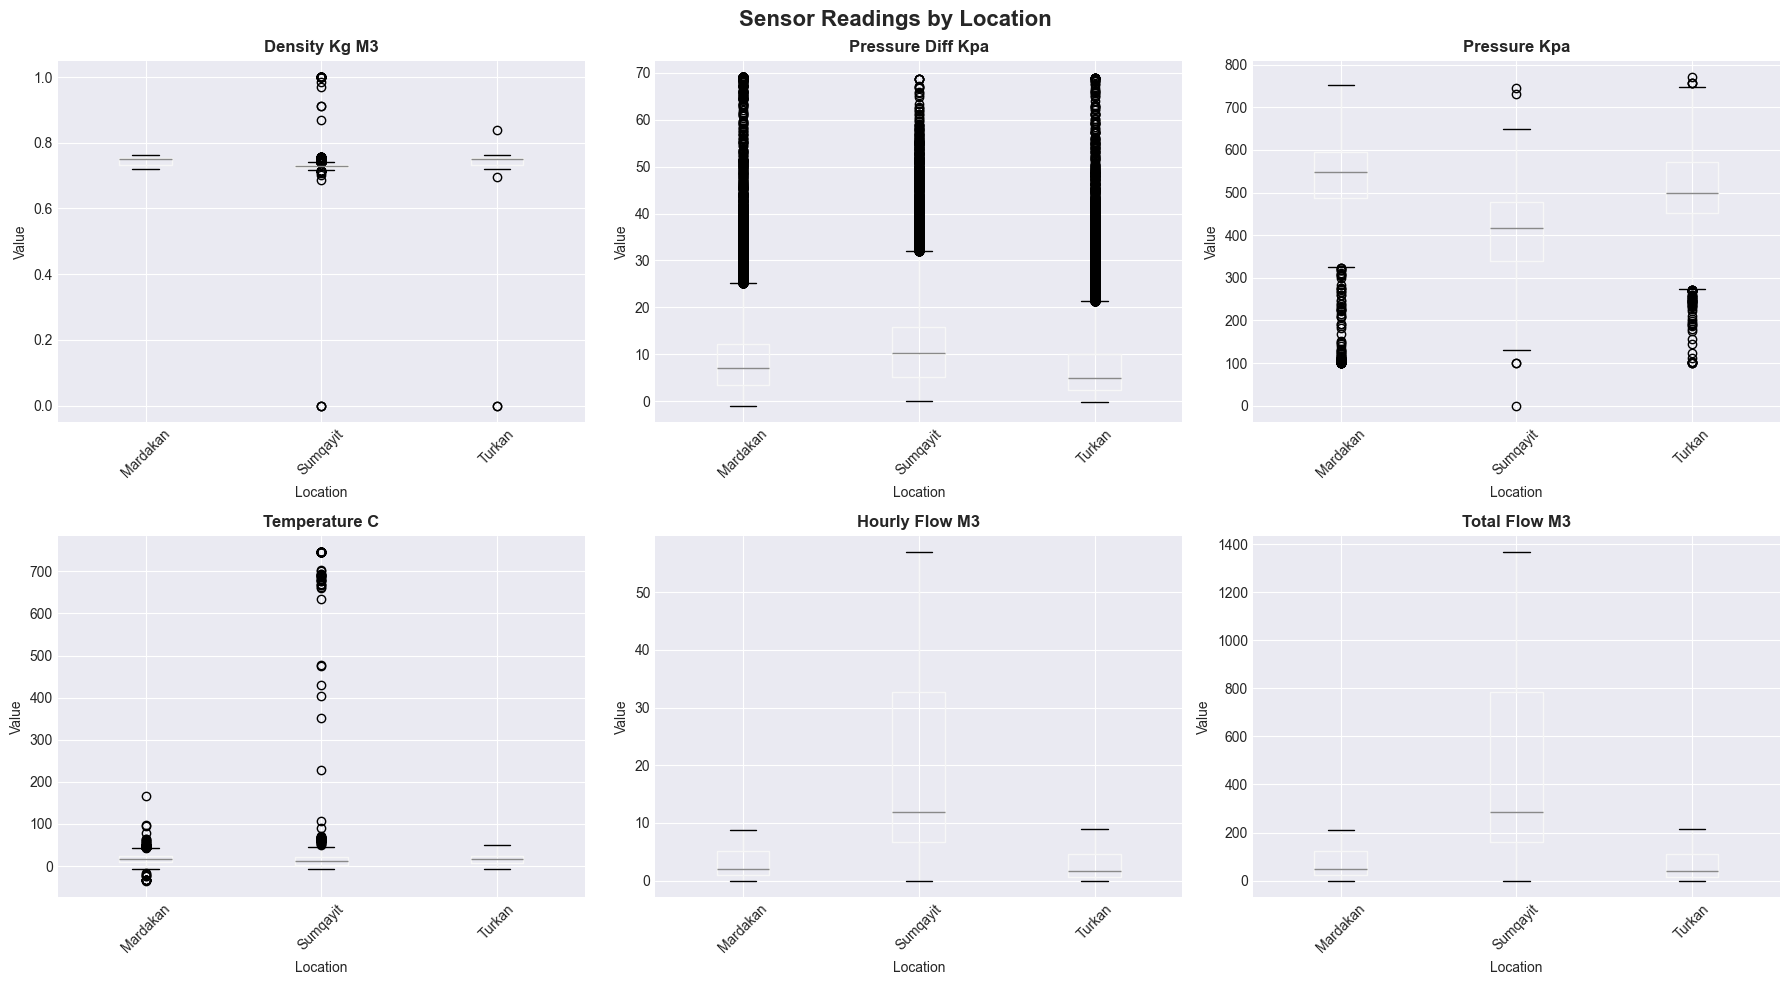

In [7]:
# Box plots comparing sensors across locations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Sensor Readings by Location', fontsize=16, fontweight='bold')

for idx, col in enumerate(sensor_cols):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]
    
    df.boxplot(column=col, by='location', ax=ax)
    ax.set_title(f'{col.replace("_", " ").title()}', fontweight='bold')
    ax.set_xlabel('Location')
    ax.set_ylabel('Value')
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.suptitle('Sensor Readings by Location', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(CHARTS_DIR / '03_location_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: charts/03_location_comparison.png")
plt.show()

### 3.5 Temporal Patterns

✓ Saved: charts/04_temporal_patterns.png


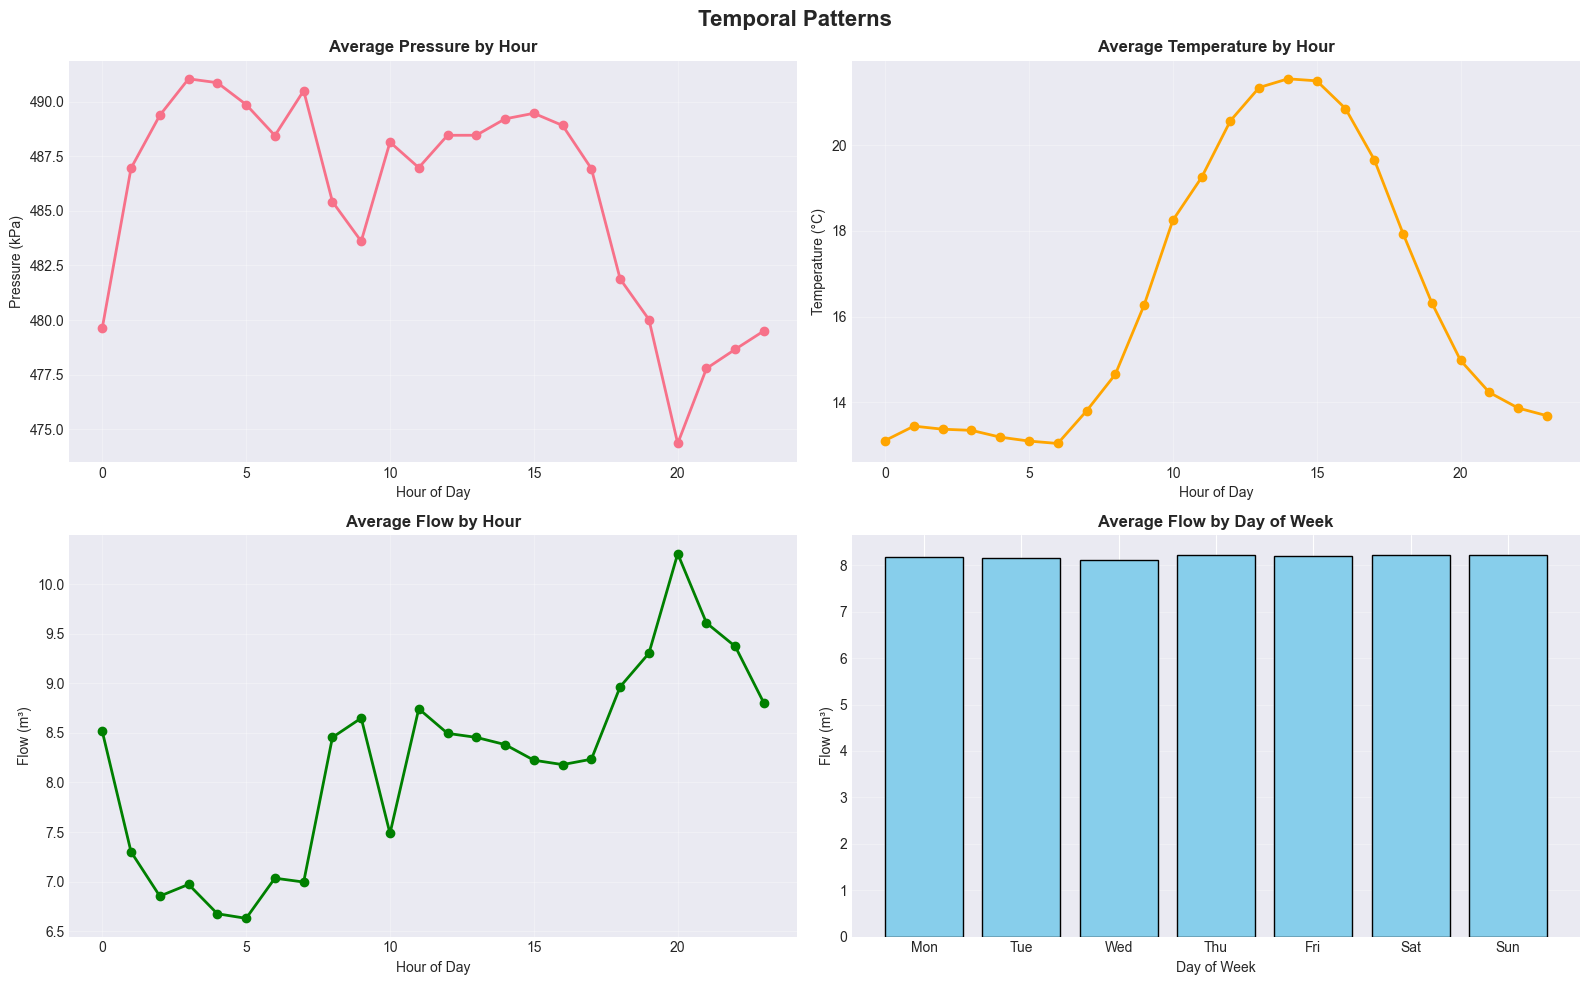

In [8]:
# Hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Temporal Patterns', fontsize=16, fontweight='bold')

# Average by hour
hourly_avg = df.groupby('hour')[['pressure_kpa', 'temperature_c', 'hourly_flow_m3']].mean()

axes[0, 0].plot(hourly_avg.index, hourly_avg['pressure_kpa'], marker='o', linewidth=2)
axes[0, 0].set_title('Average Pressure by Hour', fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Pressure (kPa)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(hourly_avg.index, hourly_avg['temperature_c'], marker='o', linewidth=2, color='orange')
axes[0, 1].set_title('Average Temperature by Hour', fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(hourly_avg.index, hourly_avg['hourly_flow_m3'], marker='o', linewidth=2, color='green')
axes[1, 0].set_title('Average Flow by Hour', fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Flow (m³)')
axes[1, 0].grid(True, alpha=0.3)

# Day of week patterns
dow_avg = df.groupby('day_of_week')['hourly_flow_m3'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(range(7), dow_avg.values, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Average Flow by Day of Week', fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Flow (m³)')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(dow_labels)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(CHARTS_DIR / '04_temporal_patterns.png', dpi=300, bbox_inches='tight')
print("✓ Saved: charts/04_temporal_patterns.png")
plt.show()

### 3.6 Time Series Sample

✓ Saved: charts/05_time_series_sample.png


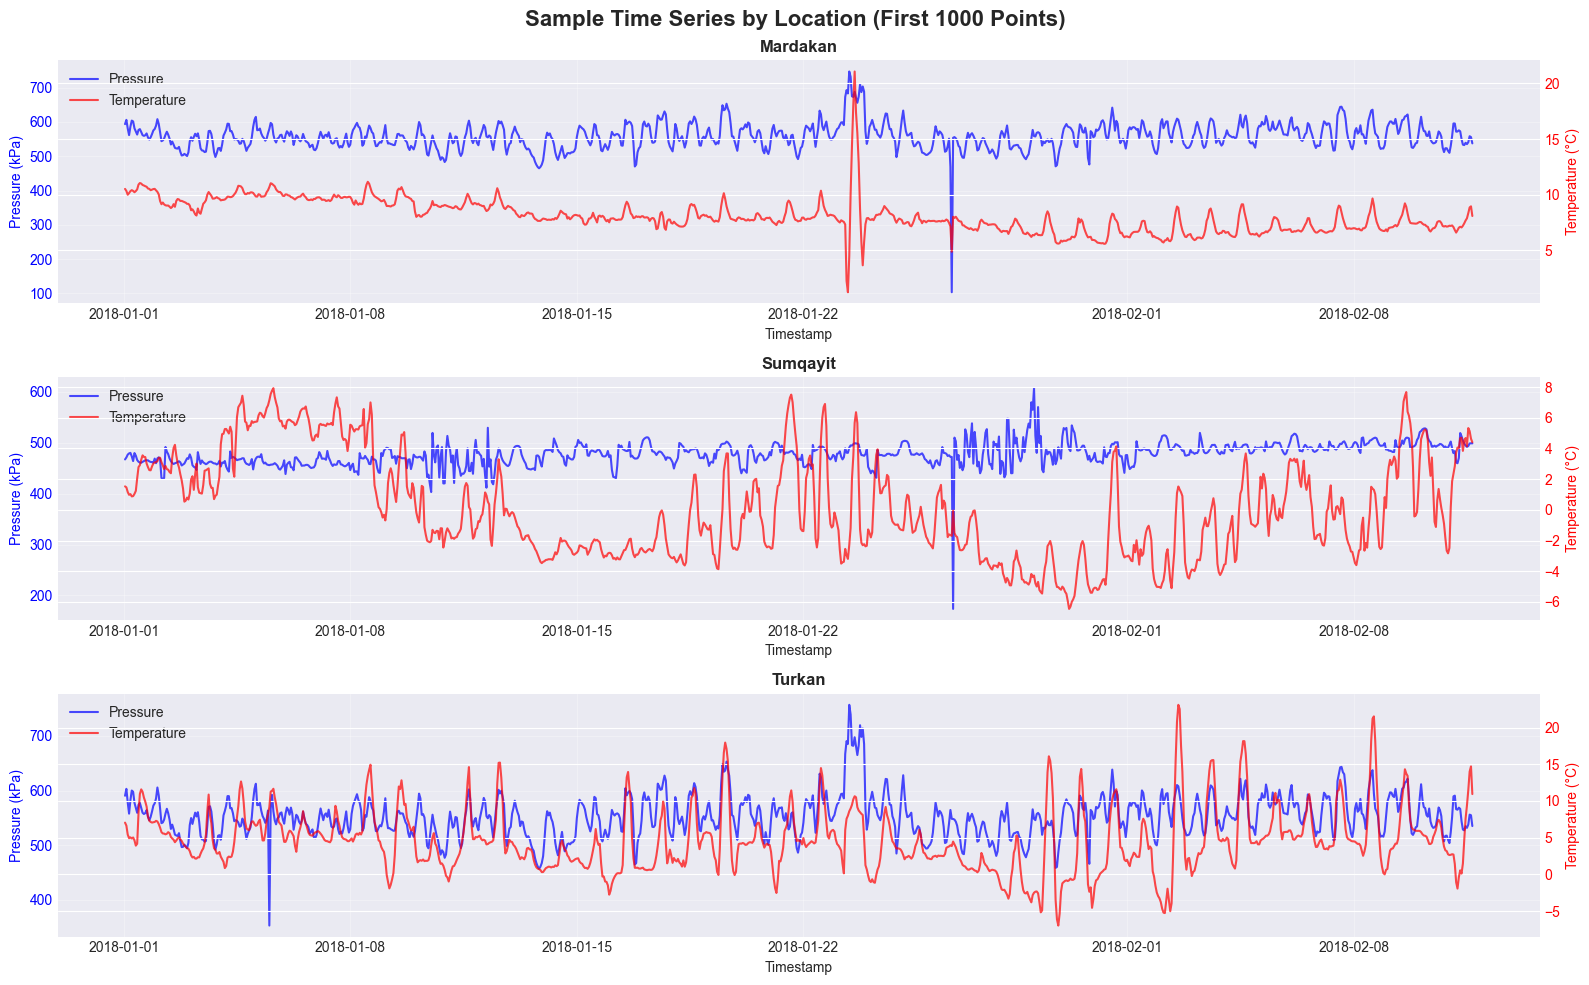


EDA COMPLETE - All charts saved to charts/


In [9]:
# Sample time series (first 1000 points from each location)
fig, axes = plt.subplots(3, 1, figsize=(16, 10))
fig.suptitle('Sample Time Series by Location (First 1000 Points)', fontsize=16, fontweight='bold')

for idx, location in enumerate(['Mardakan', 'Sumqayit', 'Turkan']):
    location_data = df[df['location'] == location].head(1000).sort_values('timestamp')
    
    ax = axes[idx]
    ax2 = ax.twinx()
    
    # Plot pressure and temperature
    line1 = ax.plot(location_data['timestamp'], location_data['pressure_kpa'], 
                    label='Pressure', color='blue', alpha=0.7)
    line2 = ax2.plot(location_data['timestamp'], location_data['temperature_c'], 
                     label='Temperature', color='red', alpha=0.7)
    
    ax.set_title(f'{location}', fontweight='bold')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Pressure (kPa)', color='blue')
    ax2.set_ylabel('Temperature (°C)', color='red')
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    ax.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.savefig(CHARTS_DIR / '05_time_series_sample.png', dpi=300, bbox_inches='tight')
print("✓ Saved: charts/05_time_series_sample.png")
plt.show()

print("\n" + "="*70)
print("EDA COMPLETE - All charts saved to charts/")
print("="*70)

## 4. Feature Preparation

In [10]:
# One-hot encode location (using 'loc_' prefix for production)
df = pd.get_dummies(df, columns=['location'], prefix='loc', drop_first=False)

print("✓ Location encoding complete")
print(f"  Location columns: {[c for c in df.columns if c.startswith('loc_')]}")

# Define feature columns (THIS IS CRITICAL - must match production code)
# IMPORTANT: Excluding temporal features (hour, day_of_week, month, year)
# to make model time-invariant and avoid false anomalies on new timestamps
FEATURE_COLUMNS = [
    "density_kg_m3",
    "pressure_diff_kpa",
    "pressure_kpa",
    "temperature_c",
    "hourly_flow_m3",
    "total_flow_m3",
    "loc_Mardakan",
    "loc_Sumqayit",
    "loc_Turkan"
]

X = df[FEATURE_COLUMNS].values
print(f"\n✓ Feature matrix: {X.shape}")
print(f"  Total features: {len(FEATURE_COLUMNS)}")
print(f"  Sensor features: 6")
print(f"  Location features: 3")
print(f"  Temporal features: EXCLUDED (for time-invariance)")

✓ Location encoding complete
  Location columns: ['loc_Mardakan', 'loc_Sumqayit', 'loc_Turkan']

✓ Feature matrix: (170289, 9)
  Total features: 9
  Sensor features: 6
  Location features: 3
  Temporal features: EXCLUDED (for time-invariance)


## 5. Print Data Statistics (for simulator calibration)

In [11]:
# Calculate statistics for each sensor
print("\n" + "="*70)
print("TRAINING DATA STATISTICS (Use these for simulator!)")
print("="*70)

stats = {}
sensor_features = ["density_kg_m3", "pressure_diff_kpa", "pressure_kpa", 
                   "temperature_c", "hourly_flow_m3", "total_flow_m3"]

for feature in sensor_features:
    mean = df[feature].mean()
    std = df[feature].std()
    min_val = df[feature].min()
    max_val = df[feature].max()
    
    stats[feature] = {
        "mean": float(mean),
        "std": float(std),
        "min": float(min_val),
        "max": float(max_val)
    }
    
    print(f"\n{feature}:")
    print(f"  Mean: {mean:.4f}")
    print(f"  Std:  {std:.4f}")
    print(f"  Min:  {min_val:.4f}")
    print(f"  Max:  {max_val:.4f}")

# Save statistics
with open(OUTPUTS_DIR / "training_statistics.json", 'w') as f:
    json.dump(stats, f, indent=2)
    
print("\n✓ Statistics saved to outputs/training_statistics.json")


TRAINING DATA STATISTICS (Use these for simulator!)

density_kg_m3:
  Mean: 0.7394
  Std:  0.0140
  Min:  0.0000
  Max:  1.0000

pressure_diff_kpa:
  Mean: 9.2100
  Std:  8.0300
  Min:  -0.9840
  Max:  69.1320

pressure_kpa:
  Mean: 485.6506
  Std:  95.8001
  Min:  0.0000
  Max:  770.9690

temperature_c:
  Mean: 16.3247
  Std:  17.3695
  Min:  -34.5680
  Max:  746.1530

hourly_flow_m3:
  Mean: 8.1903
  Std:  11.3872
  Min:  0.0000
  Max:  56.9900

total_flow_m3:
  Mean: 196.5660
  Std:  273.2937
  Min:  0.0000
  Max:  1367.7700

✓ Statistics saved to outputs/training_statistics.json


## 6. Train One-Class SVM Model

In [12]:
# Configuration
CONTAMINATION_RATE = 0.01  # 1% expected anomaly rate
RANDOM_SEED = 42

print("Training One-Class SVM...")
print(f"  Contamination rate: {CONTAMINATION_RATE*100}%")
print(f"  Random seed: {RANDOM_SEED}")

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', OneClassSVM(
        kernel='rbf',
        gamma='auto',
        nu=CONTAMINATION_RATE,  # nu = expected proportion of outliers
    ))
])

# Train
pipeline.fit(X)

print("\n✓ Model trained successfully!")

Training One-Class SVM...
  Contamination rate: 1.0%
  Random seed: 42



✓ Model trained successfully!


## 7. Test the Model

In [13]:
# Predict on training data
predictions = pipeline.predict(X)
anomaly_count = (predictions == -1).sum()
anomaly_rate = anomaly_count / len(predictions) * 100

print("\n" + "="*70)
print("MODEL TESTING")
print("="*70)
print(f"\nPredictions on training data:")
print(f"  Total: {len(predictions):,}")
print(f"  Normal: {(predictions == 1).sum():,} ({100-anomaly_rate:.2f}%)")
print(f"  Anomalies: {anomaly_count:,} ({anomaly_rate:.2f}%)")
print(f"\n✓ Anomaly rate close to {CONTAMINATION_RATE*100}%: {'YES' if abs(anomaly_rate - CONTAMINATION_RATE*100) < 0.5 else 'NO'}")


MODEL TESTING

Predictions on training data:
  Total: 170,289
  Normal: 168,585 (99.00%)
  Anomalies: 1,704 (1.00%)

✓ Anomaly rate close to 1.0%: YES


## 8. Save Artifacts for Production

In [14]:
# Save production pipeline
joblib.dump(pipeline, ARTIFACTS_DIR / "production_pipeline.joblib")
print("✓ Saved: artifacts/production_pipeline.joblib")

# Save scaler separately
joblib.dump(pipeline.named_steps['scaler'], ARTIFACTS_DIR / "scaler.joblib")
print("✓ Saved: artifacts/scaler.joblib")

# Save model separately
joblib.dump(pipeline.named_steps['model'], ARTIFACTS_DIR / "model.joblib")
print("✓ Saved: artifacts/model.joblib")

# Save feature configuration
feature_config = {
    "feature_columns": FEATURE_COLUMNS,
    "n_features": len(FEATURE_COLUMNS),
    "model_name": "One-Class SVM",
    "contamination_rate": CONTAMINATION_RATE,
    "random_seed": RANDOM_SEED,
    "training_samples": int(len(X)),
    "training_anomaly_rate": float(anomaly_rate)
}

with open(ARTIFACTS_DIR / "feature_config.json", 'w') as f:
    json.dump(feature_config, f, indent=2)
print("✓ Saved: artifacts/feature_config.json")

print("\n" + "="*70)
print("SUCCESS! All artifacts saved for production")
print("="*70)
print("\nReady to deploy!")
print("  1. Enable model in app/main.py (set MODEL_LOADED = True)")
print("  2. Update data_simulator.py with statistics from training_statistics.json")
print("  3. Restart FastAPI server")

✓ Saved: artifacts/production_pipeline.joblib
✓ Saved: artifacts/scaler.joblib
✓ Saved: artifacts/model.joblib
✓ Saved: artifacts/feature_config.json

SUCCESS! All artifacts saved for production

Ready to deploy!
  1. Enable model in app/main.py (set MODEL_LOADED = True)
  2. Update data_simulator.py with statistics from training_statistics.json
  3. Restart FastAPI server
